In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt

import seaborn as sn
import scipy.stats as st
import math

from pingouin import rcorr

from ICS_functions import *


In [2]:
import sys
import os

from sys import platform
if platform == "darwin":
    sys.path.append(os.path.dirname(os.path.realpath(__file__)) + "/..")
    smart_nlp_path = ''
elif platform == "win32":
    sys.path.append('../')
    smart_nlp_path = os.getcwd()
    smart_nlp_path = "\\".join([smart_nlp_path.split("\\")[i] for i in range(0,len(smart_nlp_path.split("\\"))-1)]+["/"])

### Data set-up
we need to ensure we include only fires that are in both summary reports and situation reports.
We also need to handle Nan values specifically for-> containment date, total personnel, and aerial

In [3]:
incident_file = smart_nlp_path+r"input data\209-PLUS\ics209-plus-wildfire\ics209-plus-wildfire\ics209-plus-wf_incidents_1999to2014.csv"
incident_summary_df = pd.read_csv(incident_file)
incident_summary_df = incident_summary_df.drop("Unnamed: 0", axis=1)
incident_summary_df = incident_summary_df.loc[incident_summary_df["START_YEAR"]>=2006].reset_index(drop=True)
print(len(incident_summary_df))

16800


C:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,13,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
preprocessed_file = smart_nlp_path+r"\output data\ICS_full_combinedtopics-Mar-10-2021\preprocessed_data.csv"
sitrep_df = pd.read_csv(preprocessed_file)
sitrep_df = sitrep_df.loc[sitrep_df["START_YEAR"]>2005].reset_index(drop=True)
print(len(sitrep_df))

53879


In [5]:
fire_ids = incident_summary_df['INCIDENT_ID'].unique()
sitrep_ids = sitrep_df['INCIDENT_ID'].unique()
sitrep_df = sitrep_df[sitrep_df['INCIDENT_ID'].isin(fire_ids)].reset_index(drop=True)
incident_summary_df =incident_summary_df[incident_summary_df['INCIDENT_ID'].isin(sitrep_ids)].reset_index(drop=True)
display(sitrep_df)
print(len(sitrep_df))
display(incident_summary_df)
print(len(incident_summary_df))

,CY,DISCOVERY_DATE,INCIDENT_ID,PCT_CONTAINED_COMPLETED,START_YEAR,TOTAL_AERIAL,TOTAL_PERSONNEL,REPORT_DOY,DISCOVERY_DOY,Combined Text
0,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,80.0,2010.0,5.000000,230.000000,197,196,"['resource', 'cactus', 'share']"
1,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010.0,5.000000,230.000000,197,196,"['resource', 'lightning strike', 'predict', 'c..."
2,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.000000,165.000000,197,196,"['resource', 'lightning strike', 'predict', 'c..."
3,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.333333,192.333333,197,196,"['valley', 'resource', 'lightning strike', 'be..."
4,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,100.0,2010.0,4.333333,192.333333,197,196,"['valley', 'resource', 'become', 'cactus', 'ma..."
...,...,...,...,...,...,...,...,...,...,...
53874,2014,2014-03-21 13:00:00,2014_VAVAS1406043_PINE CREEK,100.0,2014.0,0.000000,14.000000,82,80,['fuel']
53875,2014,2014-03-21 13:00:00,2014_VAVAS1406043_PINE CREEK,100.0,2014.0,0.000000,14.000000,82,80,['fuel']
53876,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,0.0,2014.0,1.000000,95.000000,234,232,"['edge', 'lack', 'disc', 'heavy', 'come', 'agr..."
53877,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,86.0,2014.0,1.000000,120.000000,235,232,"['perimeter', 'create', 'swing', 'accord', 'st..."


53879


,INCIDENT_ID,INCIDENT_NUMBER,INCIDENT_NAME,INCTYP_ABBREVIATION,FINAL_ACRES,CAUSE,COMPLEX,DISCOVERY_DATE,DISCOVERY_DOY,EXPECTED_CONTAINMENT_DATE,...,FOD_CAUSE_DESCR,FOD_FIRE_SIZE,FOD_COMPLEX_NAME,FOD_OBJ,FOD_LIST,FOD_ID,MTBS_ID,MTBS_FIRE_NAME,FOD_LATITUDE,FOD_LONGITUDE
0,2000_CA-RRU-062485_VALLEY COMPLEX,CA-RRU-062485,VALLEY COMPLEX,WF,1312.0,L,True,2010-07-15 15:00:00,196,2010-07-18 00:00:00,...,Lightning,1289.0,VALLEY COMPLEX,"[{""ID"" : 1386075, ""COORDS"" : (33.63888888, -11...","['{""ID"" : 1386075, ""COORDS"" : (33.63888888, -1...",1432504.0,(VALLEY COMPLEX),NaN,34.066667,-87.189444
1,2005_OK-CHA-005077_WILLIS,OK-CHA-005077,WILLIS,WF,460.0,H,False,2005-12-30 00:00:00,1,2006-01-05 16:00:00,...,['Arson' 'Missing/Undefined'],920.0,NaN,"[{""ID"" : 251856, ""COORDS"" : (33.8833, -96.8169...","['{""ID"" : 251856, ""COORDS"" : (33.8833, -96.816...",251856.0,NaN,NaN,34.066667,-87.189444
2,2005_TX-RGR-B9Y1_EVE,TX-RGR-B9Y1,EVE,WF,300.0,H,False,2005-12-24 00:00:00,358,2006-12-24 17:00:00,...,['Missing/Undefined' 'Debris Burning'],311.0,NaN,"[{""ID"" : 362578, ""COORDS"" : (35.8064, -101.393...","['{""ID"" : 362578, ""COORDS"" : (35.8064, -101.39...",362578.0,NaN,NaN,34.066667,-87.189444
3,2006_00276_MILLER COMPLEX,00276,MILLER COMPLEX,WF,300.0,L,True,2006-06-26 19:55:00,177,2006-07-03 18:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006_1224_MULTIPLE JUNE FIRES,1224,MULTIPLE JUNE FIRES,WF,21.0,L,False,2006-06-26 15:00:00,177,2006-07-01 18:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10162,2014_VAVAS1406037_AIRPORT MOUNTAIN,VAVAS1406037,Airport Mountain,WF,200.0,H,False,2014-03-19 14:00:00,78,NaN,...,Arson,375.0,NaN,"[{""ID"" : 300117756, ""COORDS"" : (37.24325, -82....","['{""ID"" : 300117756, ""COORDS"" : (37.24325, -82...",300117756.0,NaN,NaN,37.243250,-82.103528
10163,2014_VAVAS1406040_BAKERS RIDGE,VAVAS1406040,Bakers Ridge,WF,100.0,H,False,2014-03-22 12:00:00,81,NaN,...,Equipment Use,100.0,NaN,"[{""ID"" : 300083746, ""COORDS"" : (36.87027778, -...","['{""ID"" : 300083746, ""COORDS"" : (36.87027778, ...",300083746.0,NaN,NaN,36.870278,-82.286333
10164,2014_VAVAS1406041_NEIGHBOR TRAIL,VAVAS1406041,Neighbor Trail,WF,180.0,H,False,2014-03-21 12:00:00,80,NaN,...,Miscellaneous,120.0,NaN,"[{""ID"" : 300144282, ""COORDS"" : (36.71777778, -...","['{""ID"" : 300144282, ""COORDS"" : (36.71777778, ...",300144282.0,NaN,NaN,36.717778,-82.843333
10165,2014_VAVAS1406043_PINE CREEK,VAVAS1406043,Pine Creek,WF,150.0,H,False,2014-03-21 13:00:00,80,NaN,...,Missing/Undefined,150.0,NaN,"[{""ID"" : 300150138, ""COORDS"" : (37.0841667, -8...","['{""ID"" : 300150138, ""COORDS"" : (37.0841667, -...",300150138.0,NaN,NaN,37.084167,-81.910833


10167


#### NaN handeling: containment doy and discovery_doy

In [6]:
def convert_date_to_doy(date):
    days_per_month = {'1':31, '2':28, '3':31,'4':30, '5':31, '6':30, '7':31, '8':31, '9':30, '10':31, '11':30, '12':31}
    date = date.split(" ")
    if len(date)>0:
        date = date[0]
        date = date.split("-")
        month = date[1]
        day = date[2]
        doy = sum([days_per_month[str(month)] for month in range(1,int(month))])+ int(day)
        return (doy)
    else: 
        return 

In [7]:
fire_ids_to_drop = []

In [8]:
for i in range(len(incident_summary_df)):
    
    if math.isnan(incident_summary_df.iloc[i]["FOD_DISCOVERY_DOY"]):
        fire_id =  incident_summary_df.iloc[i]['INCIDENT_ID']
        sit_reps_for_fire = sitrep_df.loc[sitrep_df['INCIDENT_ID']==fire_id]
        possible_dates = sit_reps_for_fire["DISCOVERY_DOY"].unique() 
        #handles multiple start dates and fixes the summary reports and sitreps
        if len(possible_dates)>1:
            date = min(possible_dates)
            #changes the date in the sitrep
            for j in range(len(sitrep_df)):
                if sitrep_df.iloc[j]["INCIDENT_ID"]==fire_id:
                    sitrep_df.at[j,'DISCOVERY_DOY']=date
        elif len(possible_dates)==0 or math.isnan(possible_dates[0]):
            fire_ids_to_drop.append(fire_id)
        else:
            date = possible_dates[0]
        incident_summary_df.at[i,"FOD_DISCOVERY_DOY"] = date
        
    if math.isnan(incident_summary_df.iloc[i]["FOD_CONTAIN_DOY"]):
        #look at final report date, expected containment date
        fire_id =  incident_summary_df.iloc[i]['INCIDENT_ID']
        sit_reps_for_fire = sitrep_df.loc[(sitrep_df['INCIDENT_ID']==fire_id) & (sitrep_df["PCT_CONTAINED_COMPLETED"]==100.0)]
        possible_dates = sit_reps_for_fire["REPORT_DOY"].unique() 
        if len(possible_dates)>1:
            date = min(possible_dates)
        elif len(possible_dates) ==0 or math.isnan(possible_dates[0]):
            #check final report date, expected containment date
            final_report_date = convert_date_to_doy(incident_summary_df.iloc[i]['FINAL_REPORT_DATE'])
            if not math.isnan(final_report_date):
                date = final_report_date
            else: 
                expeceted_containment_date = convert_date_to_doy(incident_summary_df.iloc[i]['EXPECTED_CONTAINMENT_DATE'])
                if math.isnan(expected_containment_date):
                    fire_ids_to_drop.append(fire_id)
                else:
                    date = expected_containment_date
        else:
            date = possible_dates[0]
        incident_summary_df.at[i,"FOD_CONTAIN_DOY"] = date
        

In [9]:
print(len(set(fire_ids_to_drop)))

0


#### NaN handeling: personnel and aerial numbers

In [10]:
for i in range(len(incident_summary_df)):
    
    if math.isnan(incident_summary_df.iloc[i]["TOTAL_PERSONNEL_SUM"]):
        fire_id =  incident_summary_df.iloc[i]['INCIDENT_ID']
        sitrep_for_fire = sitrep_df.loc[sitrep_df['INCIDENT_ID']==fire_id]
        calculated_personnel_sum = sum([personnel for personnel in sitrep_for_fire["TOTAL_PERSONNEL"]])
        incident_summary_df.at[i,"TOTAL_PERSONNEL_SUM"] = calculated_personnel_sum
        #removes fires with no reported personnel
        if calculated_personnel_sum == 0:
            fire_ids_to_drop.append(fire_id)
        
    if math.isnan(incident_summary_df.iloc[i]["TOTAL_AERIAL_SUM"]):
        #confirms summaries reporting no aerial support had no aerial support, corrects if needed
        fire_id =  incident_summary_df.iloc[i]['INCIDENT_ID']
        sitrep_for_fire = sitrep_df.loc[sitrep_df['INCIDENT_ID']==fire_id]
        calculated_aerial_sum = sum([personnel for personnel in sitrep_for_fire["TOTAL_AERIAL"]])
        incident_summary_df.at[i,"TOTAL_AERIAL_SUM"] = calculated_aerial_sum
        
        

In [11]:
print(len(set(fire_ids_to_drop)))

295


#### Finalizing data

In [12]:
total_ids = [id_ for id_ in sitrep_ids if id_ not in fire_ids_to_drop]
incident_summary_df = incident_summary_df.loc[incident_summary_df['INCIDENT_ID'].isin(total_ids)].reset_index(drop=True)
sitrep_df = sitrep_df.loc[sitrep_df['INCIDENT_ID'].isin(total_ids)].reset_index(drop=True)

In [13]:
sitrep_df.to_csv(smart_nlp_path+r"\input data\ICS_filtered_preprocessed_combined.csv")

In [14]:
print(len(incident_summary_df),len(sitrep_df))

9872 53254


## FIRE TREND ANALYSIS
examining trends in frequency, acres burned, and the number of days a fire burns on average per year. Potentially add FSR (WF_MAX_FSR), number of complexes (COMPLEX), evacuations (EVACUATION_REPORTED)


In [15]:
fire_trends_cols = ["FINAL_ACRES", "FOD_DISCOVERY_DOY", "FOD_CONTAIN_DOY", "START_YEAR"]
fire_trends_df = incident_summary_df[fire_trends_cols]
fire_trends_df 

,FINAL_ACRES,FOD_DISCOVERY_DOY,FOD_CONTAIN_DOY,START_YEAR
0,1312.0,196.0,197.0,2010.0
1,460.0,1.0,5.0,2006.0
2,300.0,358.0,359.0,2006.0
3,300.0,177.0,184.0,2006.0
4,21.0,177.0,181.0,2006.0
...,...,...,...,...
9867,200.0,78.0,82.0,2014.0
9868,100.0,80.0,82.0,2014.0
9869,180.0,80.0,82.0,2014.0
9870,150.0,80.0,80.0,2014.0


In [16]:
counts = fire_trends_df["START_YEAR"].value_counts()
counts

2006.0    1690
2011.0    1560
2007.0    1218
2008.0    1214
2012.0    1101
2010.0     917
2014.0     877
2009.0     661
2013.0     634
Name: START_YEAR, dtype: int64

In [17]:
type(counts)

pandas.core.series.Series

In [18]:
years = []
count = []
for key in counts.index:
    years.append(key)
years.sort()
count = [counts[year] for year in years]

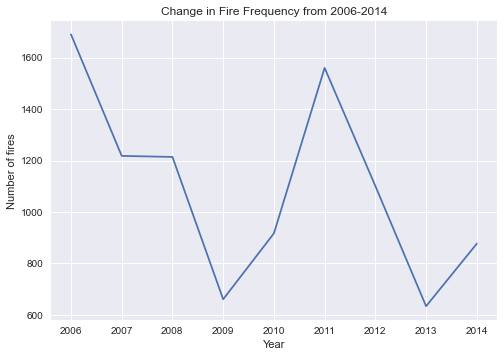

In [19]:
plt.figure()
plt.ylabel("Number of fires")
plt.xlabel("Year")
plt.title("Change in Fire Frequency from 2006-2014")
plt.plot(years, count)
plt.show()

While the above plot does not show a consistent linear trend, these results are consistent with the findings of the authors of the original papers

In [20]:
years =  fire_trends_df["START_YEAR"].unique()
years.sort()

In [21]:
years

array([2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.])

In [22]:
average_days_burning = {}
total_days_burning = {}
for year in years:
    list_of_days_burning = []
    temp_df = fire_trends_df.loc[fire_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        start_day = temp_df.iloc[i]['FOD_DISCOVERY_DOY']
        end_day = temp_df.iloc[i]["FOD_CONTAIN_DOY"]
        if not pd.isna(start_day) and not pd.isna(end_day):
            days_burn = end_day - start_day
            list_of_days_burning.append(days_burn)
    average_days_burning[year] = np.average(list_of_days_burning)
    total_days_burning[year] = np.sum(list_of_days_burning)
print(total_days_burning)

{2006.0: 13999.0, 2007.0: 12165.0, 2008.0: 10283.0, 2009.0: 11462.0, 2010.0: 11136.0, 2011.0: 14099.0, 2012.0: 14028.0, 2013.0: 12164.0, 2014.0: 11717.0}


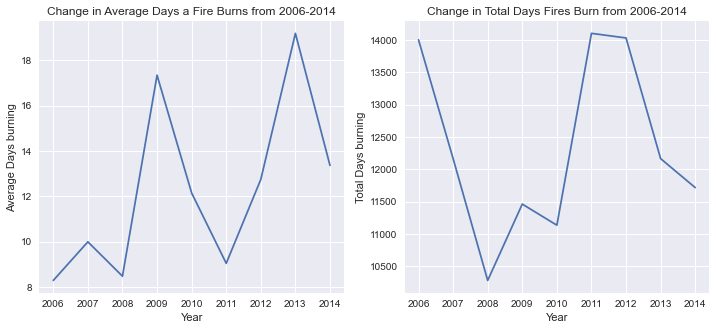

In [23]:
av_days_burn = [average_days_burning[key] for key in average_days_burning]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Days burning")
plt.xlabel("Year")
plt.title("Change in Average Days a Fire Burns from 2006-2014")
plt.plot(years, av_days_burn)

total_days_burn = [total_days_burning[key] for key in total_days_burning]
plt.subplot(1,2,2)
plt.ylabel("Total Days burning")
plt.xlabel("Year")
plt.title("Change in Total Days Fires Burn from 2006-2014")
plt.plot(years, total_days_burn)
plt.show()
plt.close()


In [24]:
total_acres = {}
average_acres = {}
for year in years:
    list_of_acres = []
    temp_df = fire_trends_df.loc[fire_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        acres = temp_df.iloc[i]['FINAL_ACRES']
        if not pd.isna(acres):
            list_of_acres.append(acres)
    average_acres[year] = np.average(list_of_acres)
    total_acres[year] = np.sum(list_of_acres)

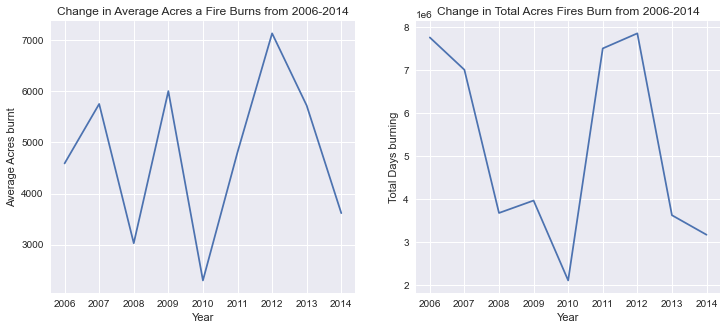

In [25]:
av_acres = [average_acres[key] for key in average_acres]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Acres burnt")
plt.xlabel("Year")
plt.title("Change in Average Acres a Fire Burns from 2006-2014")
plt.plot(years, av_acres)

total_acre = [total_acres[key] for key in total_acres]
plt.subplot(1,2,2)
plt.ylabel("Total Days burning")
plt.xlabel("Year")
plt.title("Change in Total Acres Fires Burn from 2006-2014")
plt.plot(years, total_acre)
plt.show()
plt.close()


## Testing Minmax scaling

Minmax scaling is used to maintain the data shape and trend, while scaling it to a size that is consistent accross inputs. This is useful for showing graphs with multiple lines of different values, this way you can see and compare the overall trends without losing much information. Data must be scaled before being used as an input for any model, so for our multiple regression we will use scaled data.

As we can see, the scaled graphs below look the same as the unscaled graphs above, with the only difference being the y-axis values.

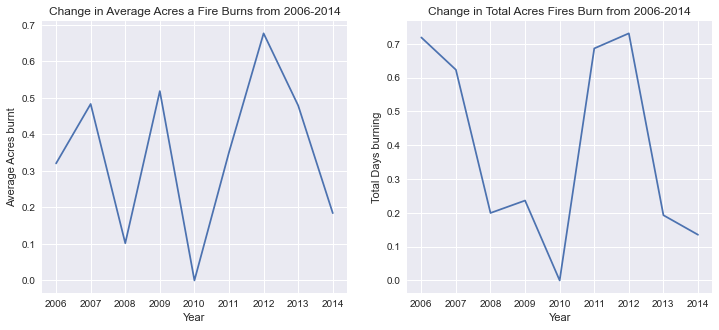

In [26]:
av_acres = [average_acres[key] for key in average_acres]
av_acres_scaled = minmax_scale(av_acres)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Acres burnt")
plt.xlabel("Year")
plt.title("Change in Average Acres a Fire Burns from 2006-2014")
plt.plot(years, av_acres_scaled)

total_acre = [total_acres[key] for key in total_acres]
total_acres_scaled = minmax_scale(total_acre)
plt.subplot(1,2,2)
plt.ylabel("Total Days burning")
plt.xlabel("Year")
plt.title("Change in Total Acres Fires Burn from 2006-2014")
plt.plot(years, total_acres_scaled)
plt.show()
plt.close()

#### Graphs

In [27]:
freq_scaled = minmax_scale(count)
av_days_burn_scaled = minmax_scale(av_days_burn)
av_acres_scaled = minmax_scale(av_acres)

total_days_burn_scaled = minmax_scale(total_days_burn)
total_acres_scaled = minmax_scale(total_acre)

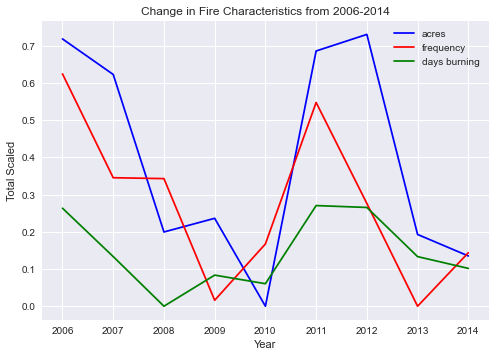

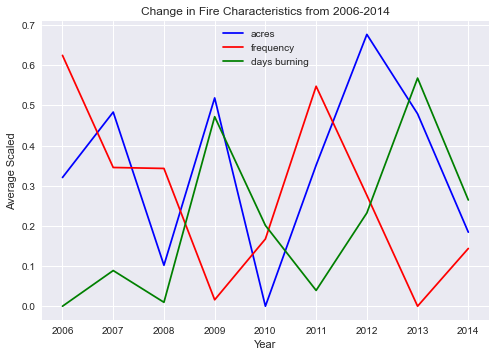

In [28]:
#plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.figure()
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Change in Fire Characteristics from 2006-2014")
plt.plot(years, total_acres_scaled, color="blue", label="acres")
plt.plot(years, freq_scaled, color="red", label="frequency")
plt.plot(years, total_days_burn_scaled, color="green", label="days burning")
plt.legend()
plt.show()

#plt.subplot(1, 2, 2)
plt.figure()
plt.ylabel("Average Scaled")
plt.xlabel("Year")
plt.title("Change in Fire Characteristics from 2006-2014")
plt.plot(years, av_acres_scaled, color="blue", label="acres")
plt.plot(years, freq_scaled, color="red", label="frequency")
plt.plot(years, av_days_burn_scaled, color="green", label="days burning")
plt.legend()
plt.show()
plt.close()

## OPERATIONAL TRENDS ANALYSIS

operational trends are examined as aerial assets (total and max in one day), personnel (total and max in one day), and projected cost.
potentially add number of sit reports (INC_MGMT_NUM_SITREPS)??

In [29]:
operational_trends_cols = ["TOTAL_AERIAL_SUM", "TOTAL_PERSONNEL_SUM", "WF_PEAK_AERIAL", "WF_PEAK_PERSONNEL", "START_YEAR","PROJECTED_FINAL_IM_COST"]
operational_trends_df = incident_summary_df[operational_trends_cols]
operational_trends_df 

,TOTAL_AERIAL_SUM,TOTAL_PERSONNEL_SUM,WF_PEAK_AERIAL,WF_PEAK_PERSONNEL,START_YEAR,PROJECTED_FINAL_IM_COST
0,29.0,2798.000000,5.0,569.000000,2010.0,2024373.0
1,0.0,42.000000,NaN,42.000000,2006.0,20000.0
2,0.0,43.000000,NaN,43.000000,2006.0,2500.0
3,1.0,2578.000000,1.0,345.000000,2006.0,1333486.0
4,7.0,1248.000000,2.0,247.000000,2006.0,300000.0
...,...,...,...,...,...,...
9867,0.0,55.500000,NaN,18.500000,2014.0,5200.0
9868,0.0,12.000000,NaN,12.000000,2014.0,500.0
9869,2.0,138.666667,1.0,69.333333,2014.0,2800.0
9870,0.0,56.000000,NaN,14.000000,2014.0,1600.0


In [30]:
operational_trends_df = operational_trends_df.loc[operational_trends_df["TOTAL_PERSONNEL_SUM"].notna()]
#remove rows with no personnel bc all fires would have some personnel, indicates incomplete reporting
operational_trends_df

,TOTAL_AERIAL_SUM,TOTAL_PERSONNEL_SUM,WF_PEAK_AERIAL,WF_PEAK_PERSONNEL,START_YEAR,PROJECTED_FINAL_IM_COST
0,29.0,2798.000000,5.0,569.000000,2010.0,2024373.0
1,0.0,42.000000,NaN,42.000000,2006.0,20000.0
2,0.0,43.000000,NaN,43.000000,2006.0,2500.0
3,1.0,2578.000000,1.0,345.000000,2006.0,1333486.0
4,7.0,1248.000000,2.0,247.000000,2006.0,300000.0
...,...,...,...,...,...,...
9867,0.0,55.500000,NaN,18.500000,2014.0,5200.0
9868,0.0,12.000000,NaN,12.000000,2014.0,500.0
9869,2.0,138.666667,1.0,69.333333,2014.0,2800.0
9870,0.0,56.000000,NaN,14.000000,2014.0,1600.0


In [31]:
total_aerial = {}
average_aerial = {}
total_person = {}
average_person = {}
for year in years:
    list_of_person = []
    list_of_aerial = []
    temp_df = operational_trends_df.loc[operational_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        aerial = temp_df.iloc[i]["WF_PEAK_AERIAL"]
        person = temp_df.iloc[i]['WF_PEAK_PERSONNEL']
        list_of_person.append(person)
        if pd.isna(aerial):
            aerial = 0
        list_of_aerial.append(aerial)
    average_aerial[year] = np.average(list_of_aerial)
    total_aerial[year] = np.sum(list_of_aerial)
    average_person[year] = np.average(list_of_person)
    total_person[year] = np.sum(list_of_person)

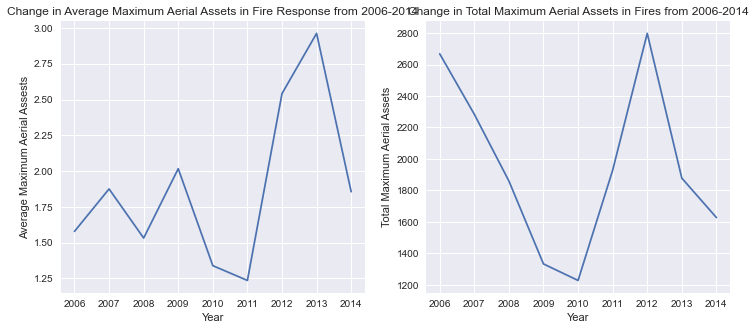

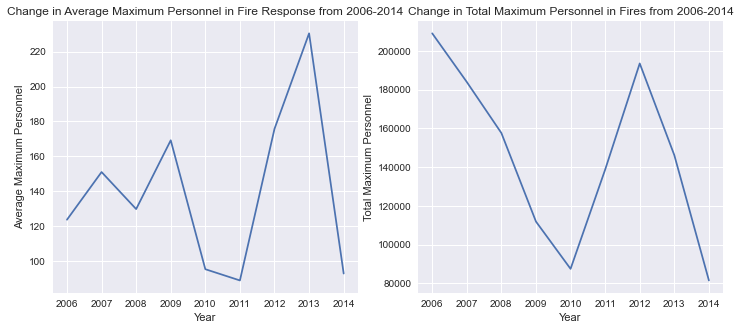

In [32]:
av_aerial = [average_aerial[key] for key in average_aerial]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Maximum Aerial Assests")
plt.xlabel("Year")
plt.title("Change in Average Maximum Aerial Assets in Fire Response from 2006-2014")
plt.plot(years, av_aerial)

total_aerial = [total_aerial[key] for key in total_aerial]
plt.subplot(1,2,2)
plt.ylabel("Total Maximum Aerial Assets")
plt.xlabel("Year")
plt.title("Change in Total Maximum Aerial Assets in Fires from 2006-2014")
plt.plot(years, total_aerial)
plt.show()
plt.close()

av_person = [average_person[key] for key in average_person]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Maximum Personnel")
plt.xlabel("Year")
plt.title("Change in Average Maximum Personnel in Fire Response from 2006-2014")
plt.plot(years, av_person)

total_person = [total_person[key] for key in total_person]
plt.subplot(1,2,2)
plt.ylabel("Total Maximum Personnel")
plt.xlabel("Year")
plt.title("Change in Total Maximum Personnel in Fires from 2006-2014")
plt.plot(years, total_person)
plt.show()
plt.close()


In [33]:
total_cost = {}
average_cost = {}
for year in years:
    list_of_cost = []
    temp_df = operational_trends_df.loc[operational_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        cost = temp_df.iloc[i]["PROJECTED_FINAL_IM_COST"]
        if not pd.isna(cost):
            list_of_cost.append(cost)
    average_cost[year] = np.average(list_of_cost)
    total_cost[year] = np.sum(list_of_cost)

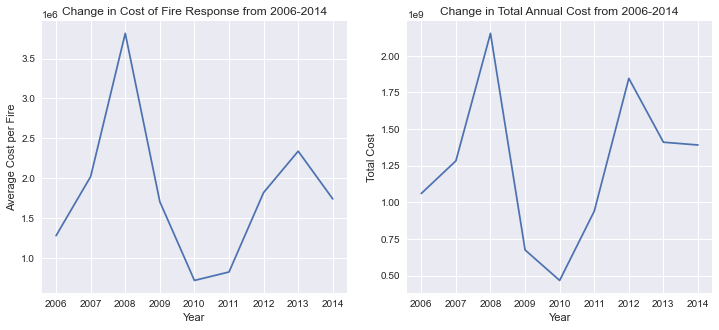

In [34]:
av_cost = [average_cost[key] for key in average_cost]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Cost per Fire")
plt.xlabel("Year")
plt.title("Change in Cost of Fire Response from 2006-2014")
plt.plot(years, av_cost)

total_cost = [total_cost[key] for key in total_cost]
plt.subplot(1,2,2)
plt.ylabel("Total Cost")
plt.xlabel("Year")
plt.title("Change in Total Annual Cost from 2006-2014")
plt.plot(years, total_cost)
plt.show()
plt.close()


#### Graphs

In [35]:
av_cost_scaled = minmax_scale(av_cost)
av_person_scaled = minmax_scale(av_person)
av_aerial_scaled = minmax_scale(av_aerial)

total_cost_scaled = minmax_scale(total_cost)
total_person_scaled = minmax_scale(total_person)
total_aerial_scaled = minmax_scale(total_aerial)

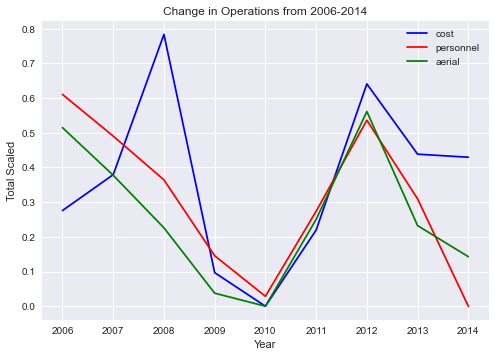

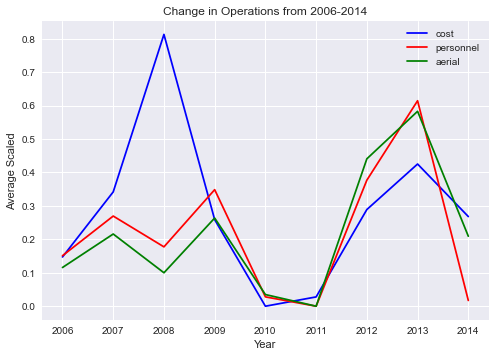

In [36]:
#plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.figure()
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Change in Operations from 2006-2014")
plt.plot(years, total_cost_scaled, color="blue", label="cost")
plt.plot(years, total_person_scaled, color="red", label="personnel")
plt.plot(years, total_aerial_scaled, color="green", label="aerial")
plt.legend()
plt.show()

#plt.subplot(1, 2, 2)
plt.figure()
plt.ylabel("Average Scaled")
plt.xlabel("Year")
plt.title("Change in Operations from 2006-2014")
plt.plot(years, av_cost_scaled, color="blue", label="cost")
plt.plot(years, av_person_scaled, color="red", label="personnel")
plt.plot(years, av_aerial_scaled, color="green", label="aerial")
plt.legend()
plt.show()
plt.close()

## INTENSITY TREND ANALYSIS
intensity is looked at as the number of injuries, number of fatalities, number of structures damaged, number of structures destroyed

In [37]:
intensity_cols = ["STR_DESTROYED_TOTAL","STR_DAMAGED_TOTAL","INJURIES_TOTAL","FATALITIES", "START_YEAR"]
intensity_df = incident_summary_df[intensity_cols]
intensity_df

,STR_DESTROYED_TOTAL,STR_DAMAGED_TOTAL,INJURIES_TOTAL,FATALITIES,START_YEAR
0,0.0,0.0,1.0,0.0,2010.0
1,0.0,0.0,1.0,0.0,2006.0
2,0.0,0.0,0.0,0.0,2006.0
3,0.0,0.0,0.0,0.0,2006.0
4,0.0,0.0,0.0,0.0,2006.0
...,...,...,...,...,...
9867,0.0,0.0,0.0,0.0,2014.0
9868,0.0,0.0,0.0,0.0,2014.0
9869,0.0,0.0,0.0,0.0,2014.0
9870,0.0,0.0,0.0,0.0,2014.0


In [38]:
total_str_des = {}
average_str_des = {}
total_str_damage = {}
average_str_damage = {}
total_injuries = {}
average_injuries = {}
total_fatalities = {}
average_fatalities = {}

for year in years:
    list_of_dest = []
    list_of_dam = []
    list_of_injury = []
    list_of_fatalities = []
    temp_df =intensity_df.loc[intensity_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        dest = temp_df.iloc[i]["STR_DESTROYED_TOTAL"]
        damage = temp_df.iloc[i]["STR_DAMAGED_TOTAL"]
        injury = temp_df.iloc[i]["INJURIES_TOTAL"]
        fatality = temp_df.iloc[i]["FATALITIES"]
        list_of_dest.append(dest)
        list_of_dam.append(damage)
        list_of_injury.append(injury)
        list_of_fatalities.append(fatality)
    total_str_des[year] = np.sum(list_of_dest)
    average_str_des[year] = np.average(list_of_dest)
    total_str_damage[year] = np.sum(list_of_dam)
    average_str_damage[year] = np.average(list_of_dam)
    total_injuries[year] = np.sum(list_of_injury)
    average_injuries[year] = np.average(list_of_injury)
    total_fatalities[year] = np.sum(list_of_fatalities)
    average_fatalities[year] = np.average(list_of_fatalities)

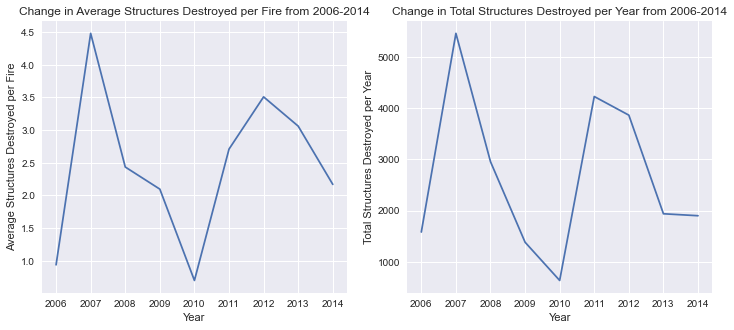

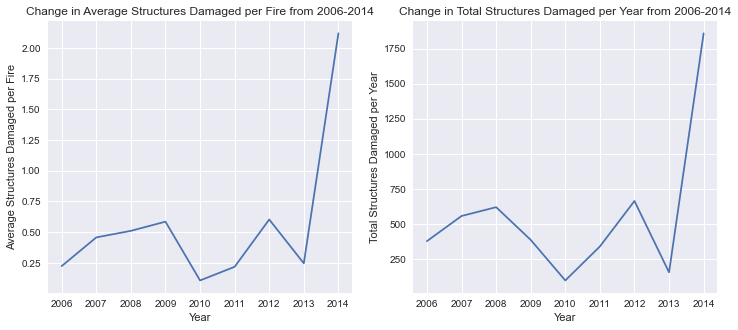

In [39]:
av_des = [average_str_des[key] for key in average_str_des]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Structures Destroyed per Fire")
plt.xlabel("Year")
plt.title("Change in Average Structures Destroyed per Fire from 2006-2014")
plt.plot(years, av_des)

total_des = [total_str_des[key] for key in total_str_des]
plt.subplot(1,2,2)
plt.ylabel("Total Structures Destroyed per Year")
plt.xlabel("Year")
plt.title("Change in Total Structures Destroyed per Year from 2006-2014")
plt.plot(years, total_des)
plt.show()
plt.close()

av_damage = [average_str_damage[key] for key in average_str_damage]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Structures Damaged per Fire")
plt.xlabel("Year")
plt.title("Change in Average Structures Damaged per Fire from 2006-2014")
plt.plot(years, av_damage)

total_damage = [total_str_damage[key] for key in total_str_damage]
plt.subplot(1,2,2)
plt.ylabel("Total Structures Damaged per Year")
plt.xlabel("Year")
plt.title("Change in Total Structures Damaged per Year from 2006-2014")
plt.plot(years, total_damage)
plt.show()
plt.close()


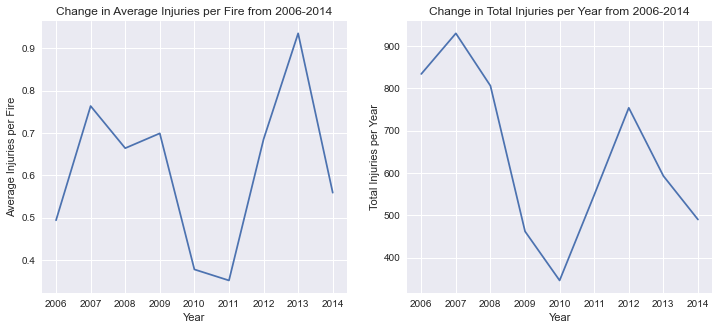

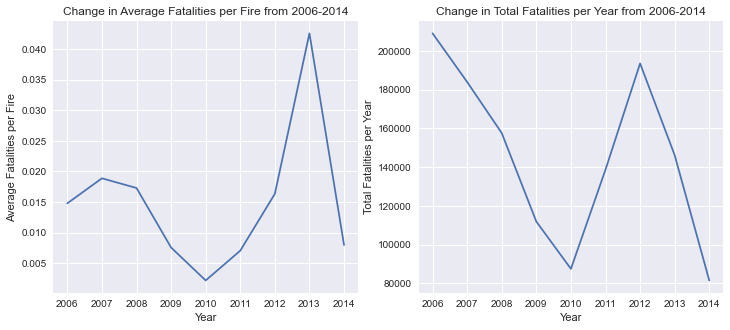

In [40]:
av_injury = [average_injuries[key] for key in average_injuries]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Injuries per Fire")
plt.xlabel("Year")
plt.title("Change in Average Injuries per Fire from 2006-2014")
plt.plot(years, av_injury)

total_injury = [total_injuries[key] for key in total_injuries]
plt.subplot(1,2,2)
plt.ylabel("Total Injuries per Year")
plt.xlabel("Year")
plt.title("Change in Total Injuries per Year from 2006-2014")
plt.plot(years, total_injury)
plt.show()
plt.close()

av_fatality = [average_fatalities[key] for key in average_fatalities]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Fatalities per Fire")
plt.xlabel("Year")
plt.title("Change in Average Fatalities per Fire from 2006-2014")
plt.plot(years, av_fatality)

total_fatality = [total_fatalities[key] for key in total_fatalities]
plt.subplot(1,2,2)
plt.ylabel("Total Fatalities per Year")
plt.xlabel("Year")
plt.title("Change in Total Fatalities per Year from 2006-2014")
plt.plot(years, total_person)
plt.show()
plt.close()


#### Graphs

In [41]:
total_fatality_scaled = minmax_scale(total_fatality)
total_injury_scaled = minmax_scale(total_injury)
total_damage_scaled = minmax_scale(total_damage)
total_des_scaled = minmax_scale(total_des)

av_fatality_scaled = minmax_scale(av_fatality)
av_injury_scaled = minmax_scale(av_injury)
av_damage_scaled = minmax_scale(av_damage)
av_des_scaled = minmax_scale(av_des)

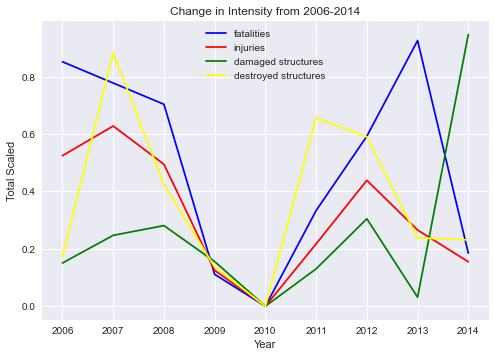

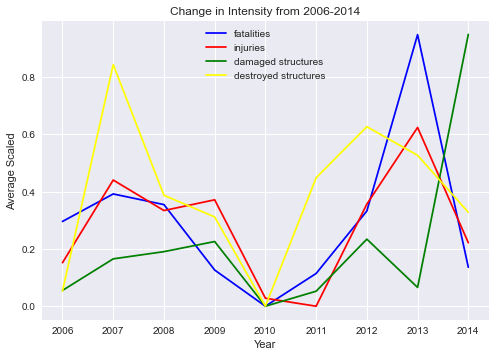

In [42]:
plt.figure()#(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Change in Intensity from 2006-2014")
plt.plot(years, total_fatality_scaled, color="blue", label="fatalities")
plt.plot(years, total_injury_scaled, color="red", label="injuries")
plt.plot(years, total_damage_scaled, color="green", label="damaged structures")
plt.plot(years, total_des_scaled, color="yellow", label="destroyed structures")
plt.legend()
plt.show()

#plt.subplot(1, 2, 2)
plt.figure()
plt.ylabel("Average Scaled")
plt.xlabel("Year")
plt.title("Change in Intensity from 2006-2014")
plt.plot(years, av_fatality_scaled, color="blue", label="fatalities")
plt.plot(years, av_injury_scaled, color="red", label="injuries")
plt.plot(years, av_damage_scaled, color="green", label="damaged structures")
plt.plot(years, av_des_scaled, color="yellow", label="destroyed structures")
plt.legend()
plt.show()
plt.close()

## Correlation Matrix

In [43]:
avs_df = pd.DataFrame({
    "fire frequency": count,
    "average days fire burns": av_days_burn,
    "average acres fire burns": av_acres,
    "average aerial assets per fire": av_aerial,
    "average personnel per fire": av_person,
    "average cost per fire": av_cost,
    "average structures damaged per fire": av_damage,
    "average structures destroyed per fire": av_des,
    "average injuries per fire": av_injury,
    "average fatalities per fire": av_fatality
})

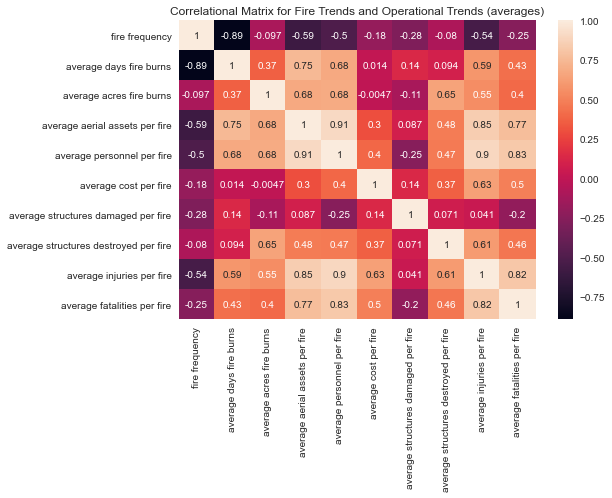

In [44]:
corrMatrix = avs_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("Correlational Matrix for Fire Trends and Operational Trends (averages)")
plt.show()

As seen above, fire frequency is negatively correlated with assets, indicating higher frequencies may be smaller fires, where lower frequencies are related to larger fires, thus more assets. 

The average days the fire burns is weakly correlated with max assets, would likely be closer correlated with total assets accross an operation. Negatively correlated with fire frequency, indication longer fires occur less frequently.

average acres burned is moderately positively correlated with assets, but for some reason is negatively correlated with days burning (could be due to outliers)

average maximum aerial assets is strongest correlated with personnel, which makes sense. Also positively correlated with acres burned, days burning, and cost, indicating more aerial support is needed in more intense fires.

average maximum personnel is positively correlated with acres burned and days burning

cost is most strongly associated with days burning, assets, and personnel, but it is still moderate. Cost can likely be explained better by number of structures damages

In [45]:
totals_df = pd.DataFrame({
    "fire frequency": count,
    "total days fires burned": total_days_burn,
    "total acres fires burned": total_acre,
    "total aerial assets": total_aerial,
    "total personnel": total_person,
    "total cost": total_cost,
    "total structures damaged": total_damage,
    "total structures destroyed": total_des,
    "total injuries": total_injury,
    "total fatalities": total_fatality
})

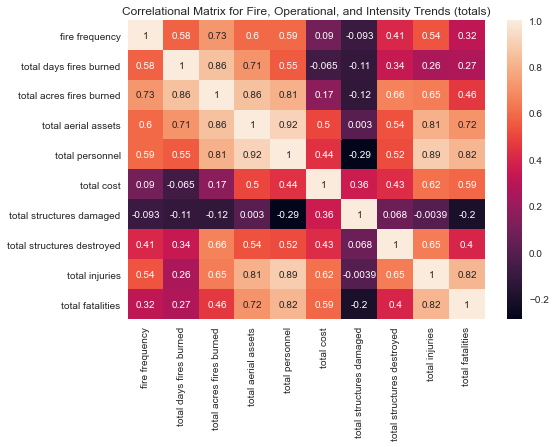

In [46]:
corrMatrix = totals_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("Correlational Matrix for Fire, Operational, and Intensity Trends (totals)")
plt.show()

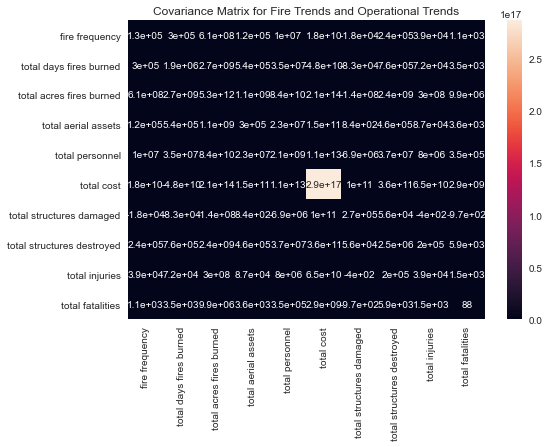

In [47]:
covMatrix = pd.DataFrame.cov(totals_df)
sn.heatmap(covMatrix, annot=True)
plt.title("Covariance Matrix for Fire Trends and Operational Trends")
plt.show()

In [48]:
totals = {"fire frequency": count,
    "total days fires burned": total_days_burn,
    "total acres fires burned": total_acre,
    "total aerial assets": total_aerial,
    "total personnel": total_person,
    "total cost": total_cost,
    "total structures damaged": total_damage,
    "total structures destroyed": total_des,
    "total injuries": total_injury,
    "total fatalities": total_fatality}
averages = {
    "fire frequency": count,
    "average days fire burns": av_days_burn,
    "average acres fire burns": av_acres,
    "average aerial assets per fire": av_aerial,
    "average personnel per fire": av_person,
    "average cost per fire": av_cost,
    "average structures damaged per fire": av_damage,
    "average structures destroyed per fire": av_des,
    "average injuries per fire": av_injury,
    "average fatalities per fire": av_fatality}

totals_scaled = {feature:minmax_scale(totals[feature]) for feature in totals}

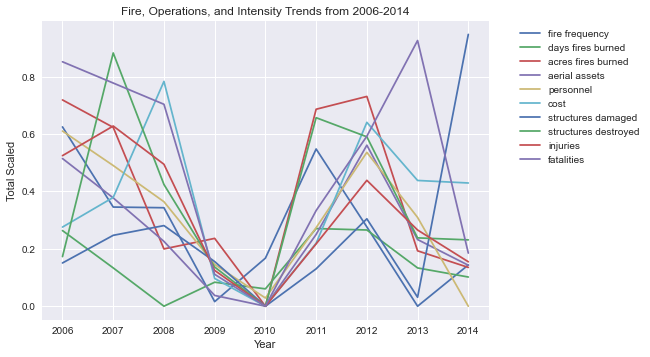

In [78]:
plt.figure()
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Fire, Operations, and Intensity Trends from 2006-2014")
for feature in totals_scaled:
    plt.plot(years, totals_scaled[feature], label=feature.replace("total ",""))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## HAZARD METRIC ANALYSIS

In [49]:
hazard_df = sitrep_df

time_of_occurence_days = {"resources":{str(year):[] for year in years}, "traffic":{str(year):[] for year in years}, "grounded":{str(year):[] for year in years}}
time_of_occurence_pct_contained = {"resources":{str(year):[] for year in years}, "traffic":{str(year):[] for year in years}, "grounded":{str(year):[] for year in years}}
frequency = {"resources":{str(year):0 for year in years}, "traffic":{str(year):0 for year in years}, "grounded":{str(year):0 for year in years}}
fires = {"resources":{str(year):[] for year in years}, "traffic":{str(year):[] for year in years}, "grounded":{str(year):[] for year in years}}

In [50]:
hazard_df = hazard_df.loc[hazard_df["START_YEAR"]>2005]
years = hazard_df["START_YEAR"].unique()
years.sort()
hazard_df

,CY,DISCOVERY_DATE,INCIDENT_ID,PCT_CONTAINED_COMPLETED,START_YEAR,TOTAL_AERIAL,TOTAL_PERSONNEL,REPORT_DOY,DISCOVERY_DOY,Combined Text
0,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,80.0,2010.0,5.000000,230.000000,197,196,"['resource', 'cactus', 'share']"
1,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010.0,5.000000,230.000000,197,196,"['resource', 'lightning strike', 'predict', 'c..."
2,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.000000,165.000000,197,196,"['resource', 'lightning strike', 'predict', 'c..."
3,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.333333,192.333333,197,196,"['valley', 'resource', 'lightning strike', 'be..."
4,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,100.0,2010.0,4.333333,192.333333,197,196,"['valley', 'resource', 'become', 'cactus', 'ma..."
...,...,...,...,...,...,...,...,...,...,...
53249,2014,2014-03-21 13:00:00,2014_VAVAS1406043_PINE CREEK,100.0,2014.0,0.000000,14.000000,82,80,['fuel']
53250,2014,2014-03-21 13:00:00,2014_VAVAS1406043_PINE CREEK,100.0,2014.0,0.000000,14.000000,82,80,['fuel']
53251,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,0.0,2014.0,1.000000,95.000000,234,232,"['edge', 'lack', 'disc', 'heavy', 'come', 'agr..."
53252,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,86.0,2014.0,1.000000,120.000000,235,232,"['perimeter', 'create', 'swing', 'accord', 'st..."


In [51]:
for year in years:
    temp_df = hazard_df.loc[hazard_df["START_YEAR"]==year]
    fire_ids = temp_df["INCIDENT_ID"].unique()
    for id_ in fire_ids:
        temp_fire_df = temp_df.loc[temp_df["INCIDENT_ID"]==id_]
        start_date = temp_fire_df["DISCOVERY_DOY"].unique() #should only have one start date
        if len(start_date) != 1: 
            #print("multiple start dates", start_date)
            start_date = min(start_date)
        else: 
            start_date = start_date[0]
        if start_date == 365:
                start_date = 0
            #print(start_date)
        for i in range(len(temp_fire_df)):
            text = temp_fire_df.iloc[i]["Combined Text"]
            #check for resource hazard
            if (("resource" in text) or ("crew" in text)) and (("limited" in text) or ("share" in text) or ("lack" in text) or ("fatigue" in text)):
                time_of_hazard = int(temp_fire_df.iloc[i]["REPORT_DOY"])
                if time_of_hazard<start_date: 
                    #print(time_of_hazard, start_date)
                    if time_of_hazard<30: #report day is days since start, not doy 
                        time_of_hazard+=start_date
                    else: #start and report day were incorrectly switched
                        #print(time_of_hazard, start_date)
                        temp_start = start_date
                        start_date = time_of_hazard
                        time_of_hazard = temp_start
                        #print(time_of_hazard, start_date)
                time_of_occurence_days["resources"][str(year)].append(time_of_hazard-int(start_date))
                time_of_occurence_pct_contained["resources"][str(year)].append(temp_fire_df.iloc[i]["PCT_CONTAINED_COMPLETED"])
                fires["resources"][str(year)].append(id_)
                frequency["resources"][str(year)] += 1
                
            #check for traffic hazard
            if (("highway" in text) or ("road" in text)) and (("close" in text) or ("closure" in text)):
                time_of_hazard = int(temp_fire_df.iloc[i]["REPORT_DOY"])
                time_of_occurence_days["traffic"][str(year)].append(time_of_hazard-int(start_date))
                time_of_occurence_pct_contained["traffic"][str(year)].append(temp_fire_df.iloc[i]["PCT_CONTAINED_COMPLETED"])
                fires["traffic"][str(year)].append(id_)
                frequency["traffic"][str(year)] += 1
                
            #check for grounded hazard
            if (("ground" in text)) and (("aircraft" in text) or ("helicopter" in text) or ("heli" in text) or ("copter" in text) or ("aerial" in text) or ("tanker" in text)):
                time_of_hazard = int(temp_fire_df.iloc[i]["REPORT_DOY"])
                time_of_occurence_days["grounded"][str(year)].append(time_of_hazard-int(start_date))
                time_of_occurence_pct_contained["grounded"][str(year)].append(temp_fire_df.iloc[i]["PCT_CONTAINED_COMPLETED"])
                fires["grounded"][str(year)].append(id_)
                frequency["grounded"][str(year)] += 1

In [52]:
def remove_outliers(data, threshold=1.5):
    #print(data)
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.75)
    IQR = Q3 - Q1
    new_data = [pt for pt in data if (pt>(Q1-1.5*IQR)) and (pt<(Q3+1.5*IQR))]
    return new_data

In [53]:
#removing outliers from data using inter-quartile-range
time_of_occurence_days
time_of_occurence_pct_contained 
for year in years:
    time_of_occurence_days["resources"][str(year)] = remove_outliers(time_of_occurence_days["resources"][str(year)])
    time_of_occurence_pct_contained["resources"][str(year)] = remove_outliers(time_of_occurence_pct_contained["resources"][str(year)])
    time_of_occurence_days["traffic"][str(year)] = remove_outliers(time_of_occurence_days["traffic"][str(year)])
    time_of_occurence_pct_contained["traffic"][str(year)] = remove_outliers(time_of_occurence_pct_contained["traffic"][str(year)])
    time_of_occurence_days["grounded"][str(year)] = remove_outliers(time_of_occurence_days["grounded"][str(year)])
    time_of_occurence_pct_contained["grounded"][str(year)] = remove_outliers(time_of_occurence_pct_contained["grounded"][str(year)])

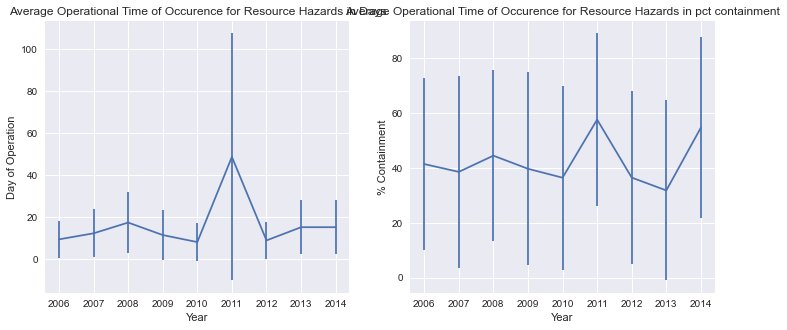

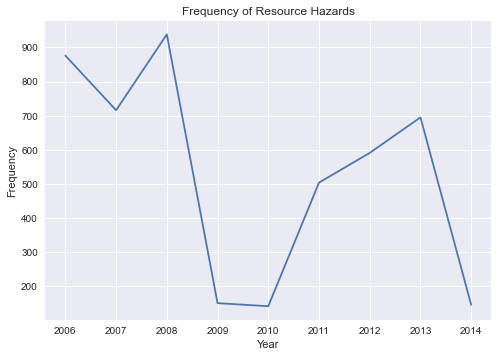

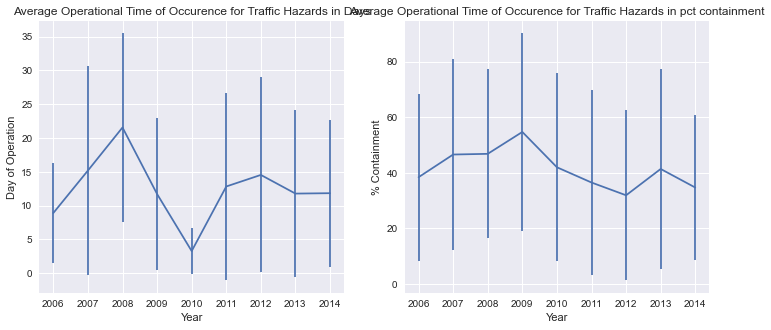

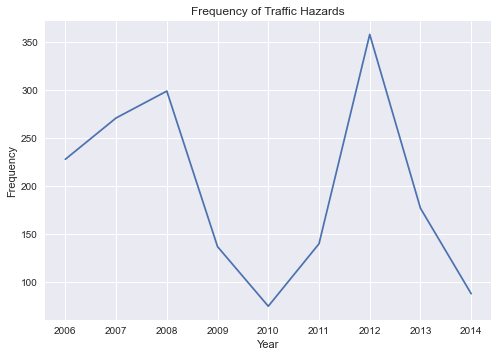

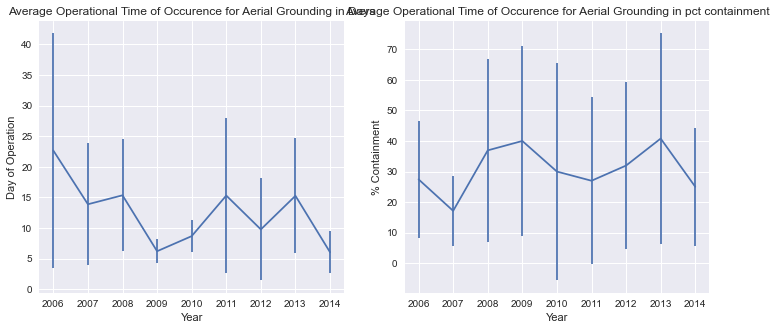

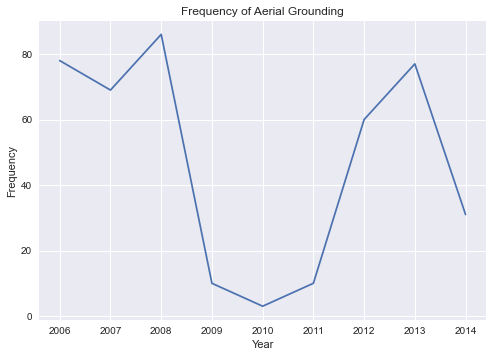

In [54]:
#display TS results for each hazard and metric

#resources:
av_resource_time = [np.average(time_of_occurence_days["resources"][year]) for year in time_of_occurence_days["resources"]]
std_devs_resource_time = [np.std(time_of_occurence_days["resources"][year]) for year in time_of_occurence_days["resources"]]

#print(av_resource_time, len(av_resource_time), len(years))
av_resource_pct = [np.average(time_of_occurence_pct_contained ["resources"][year]) for year in time_of_occurence_pct_contained ["resources"]]
std_devs_resource_pct = [np.std(time_of_occurence_pct_contained ["resources"][year]) for year in time_of_occurence_pct_contained ["resources"]]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Average Operational Time of Occurence for Resource Hazards in Days")
plt.xlabel("Year")
plt.ylabel("Day of Operation")
plt.errorbar(years, av_resource_time, yerr=std_devs_resource_time)
plt.subplot(1, 2, 2)
plt.title("Average Operational Time of Occurence for Resource Hazards in pct containment")
plt.xlabel("Year")
plt.ylabel("% Containment")
plt.errorbar(years, av_resource_pct, yerr=std_devs_resource_pct)

resource_freq = [frequency["resources"][year] for year in frequency["resources"]]
plt.figure()
plt.title("Frequency of Resource Hazards")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.plot(years,resource_freq)

#traffic:
av_traffic_time = [np.average(time_of_occurence_days["traffic"][year]) for year in time_of_occurence_days["traffic"]]
std_devs_traffic_time = [np.std(time_of_occurence_days["traffic"][year]) for year in time_of_occurence_days["traffic"]]

av_traffic_pct = [np.average(time_of_occurence_pct_contained ["traffic"][year]) for year in time_of_occurence_pct_contained ["traffic"]]
std_devs_traffic_pct = [np.std(time_of_occurence_pct_contained ["traffic"][year]) for year in time_of_occurence_pct_contained ["traffic"]]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Average Operational Time of Occurence for Traffic Hazards in Days")
plt.xlabel("Year")
plt.ylabel("Day of Operation")
plt.errorbar(years, av_traffic_time, yerr=std_devs_traffic_time)
plt.subplot(1, 2, 2)
plt.title("Average Operational Time of Occurence for Traffic Hazards in pct containment")
plt.xlabel("Year")
plt.ylabel("% Containment")
plt.errorbar(years, av_traffic_pct, yerr=std_devs_traffic_pct)

traffic_freq = [frequency["traffic"][year] for year in frequency["traffic"]]
plt.figure()
plt.title("Frequency of Traffic Hazards")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.plot(years,traffic_freq)

#grounded:
av_grounded_time = [np.average(time_of_occurence_days["grounded"][year]) for year in time_of_occurence_days["grounded"]]
std_devs_grounded_time = [np.std(time_of_occurence_days["grounded"][year]) for year in time_of_occurence_days["grounded"]]

av_grounded_pct = [np.average(time_of_occurence_pct_contained ["grounded"][year]) for year in time_of_occurence_pct_contained ["grounded"]]
std_devs_grounded_pct = [np.std(time_of_occurence_pct_contained ["grounded"][year]) for year in time_of_occurence_pct_contained ["grounded"]]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Average Operational Time of Occurence for Aerial Grounding in Days")
plt.xlabel("Year")
plt.ylabel("Day of Operation")
plt.errorbar(years, av_grounded_time, yerr=std_devs_grounded_time)
plt.subplot(1, 2, 2)
plt.title("Average Operational Time of Occurence for Aerial Grounding in pct containment")
plt.xlabel("Year")
plt.ylabel("% Containment")
plt.errorbar(years, av_grounded_pct, yerr=std_devs_grounded_pct)

grounded_freq = [frequency["grounded"][year] for year in frequency["grounded"]]
plt.figure()
plt.title("Frequency of Aerial Grounding")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.plot(years, grounded_freq)


### Hazards, metrics, primary results table

In [55]:
#display averages across years in a table
data = {"hazard":["resource availability", "public traffic closures", "aerial groundings"],
        "operational time to occurence (days)": [],
        "operational time to occurence (% containment)": [],
       }
ground_time = np.average([time for year in years for time in time_of_occurence_days["grounded"][str(year)]])
traffic_time = np.average([time for year in years for time in time_of_occurence_days["traffic"][str(year)]])
resource_time = np.average([time for year in years for time in time_of_occurence_days["resources"][str(year)]]) 
data["operational time to occurence (days)"] = [resource_time, traffic_time, ground_time]

#ground_time_std = np.std([time for year in years for time in time_of_occurence_days["grounded"][str(year)]])
#traffic_time_std = np.std([time for year in years for time in time_of_occurence_days["traffic"][str(year)]])
#resource_time_std = np.std([time for year in years for time in time_of_occurence_days["resources"][str(year)]])

ground_time_data = [time for year in years for time in time_of_occurence_days["grounded"][str(year)]]
traffic_time_data = [time for year in years for time in time_of_occurence_days["traffic"][str(year)]]
resource_time_data = [time for year in years for time in time_of_occurence_days["resources"][str(year)]]
ground_time_interval = st.t.interval(alpha=0.95, df=len(ground_time_data)-1, loc=np.mean(ground_time_data), scale=st.sem(ground_time_data))
traffic_time_interval = st.t.interval(alpha=0.95, df=len(traffic_time_data)-1, loc=np.mean(traffic_time_data), scale=st.sem(traffic_time_data))
resource_time_interval = st.t.interval(alpha=0.95, df=len(resource_time_data)-1, loc=np.mean(resource_time_data), scale=st.sem(resource_time_data))
data["operational time to occurence interval (days)"] = [resource_time_interval, traffic_time_interval, ground_time_interval]

ground_pct = np.average([pct for year in years for pct in time_of_occurence_pct_contained["grounded"][str(year)]])
traffic_pct = np.average([pct for year in years for pct in time_of_occurence_pct_contained["traffic"][str(year)]])
resource_pct = np.average([pct for year in years for pct in time_of_occurence_pct_contained["resources"][str(year)]])
data["operational time to occurence (% containment)"] = [resource_pct, traffic_pct, ground_pct]

ground_pct_data = [time for year in years for time in time_of_occurence_pct_contained["grounded"][str(year)]]
traffic_pct_data = [time for year in years for time in time_of_occurence_pct_contained["traffic"][str(year)]]
resource_pct_data = [time for year in years for time in time_of_occurence_pct_contained["resources"][str(year)]]
ground_pct_interval = st.t.interval(alpha=0.95, df=len(ground_pct_data)-1, loc=np.mean(ground_pct_data), scale=st.sem(ground_pct_data))
traffic_pct_interval = st.t.interval(alpha=0.95, df=len(traffic_pct_data)-1, loc=np.mean(traffic_pct_data), scale=st.sem(traffic_pct_data))
resource_pct_interval = st.t.interval(alpha=0.95, df=len(resource_pct_data)-1, loc=np.mean(resource_pct_data), scale=st.sem(resource_pct_data))
data["operational time to occurence interval (% containment)"] = [resource_pct_interval, traffic_pct_interval, ground_pct_interval]

#ground_pct_std = np.std([pct for year in years for pct in time_of_occurence_pct_contained["grounded"][str(year)]])
#traffic_pct_std = np.std([pct for year in years for pct in time_of_occurence_pct_contained["traffic"][str(year)]])
#resource_pct_std = np.std([pct for year in years for pct in time_of_occurence_pct_contained["resources"][str(year)]])

#ground_sum = np.sum([frequency["grounded"][year] for year in frequency["grounded"]])
#traffic_sum = np.sum([frequency["traffic"][year] for year in frequency["traffic"]])
#resources_sum = np.sum([frequency["resources"][year] for year in frequency["resources"]])

ground_sum = np.sum([len(set(fires["grounded"][year])) for year in fires["grounded"]])
traffic_sum = np.sum([len(set(fires["traffic"][year])) for year in fires["traffic"]])
resources_sum = np.sum([len(set(fires["resources"][year])) for year in fires["resources"]])

ground_rate_years = ground_sum/len(years)
traffic_rate_years = traffic_sum/len(years)
resources_rate_years = resources_sum/len(years)
data["average rate of occurence (per year)"] = [resources_rate_years, traffic_rate_years, ground_rate_years]

#total_fires = len(hazard_df)
total_fires = len(hazard_df["INCIDENT_ID"].unique())

ground_rate_fires = total_fires/ground_sum
traffic_rate_fires = total_fires/traffic_sum
resources_rate_fires = total_fires/resources_sum
data["average rate of occurence (fires per occurence)"] = [resources_rate_fires, traffic_rate_fires, ground_rate_fires]

data["total frequency"] = [resources_sum, traffic_sum, ground_sum]
for d in data:
    print(len(data[d]),d,type(data[d]))
data_df = pd.DataFrame(data)
data_df

3 hazard <class 'list'>
3 operational time to occurence (days) <class 'list'>
3 operational time to occurence (% containment) <class 'list'>
3 operational time to occurence interval (days) <class 'list'>
3 operational time to occurence interval (% containment) <class 'list'>
3 average rate of occurence (per year) <class 'list'>
3 average rate of occurence (fires per occurence) <class 'list'>
3 total frequency <class 'list'>


,hazard,operational time to occurence (days),operational time to occurence (% containment),operational time to occurence interval (days),operational time to occurence interval (% containment),average rate of occurence (per year),average rate of occurence (fires per occurence),total frequency
0,resource availability,16.726952,41.515693,"(16.001365084183867, 17.45253875348706)","(40.56871149543709, 42.462673510916154)",104.000000,10.547009,936
1,public traffic closures,13.953747,41.077986,"(13.305417141148004, 14.60207700405106)","(39.53743055416308, 42.61854214208266)",44.555556,24.618454,401
2,aerial groundings,14.825243,31.414500,"(13.615344197548884, 16.035141239344316)","(28.716290730671926, 34.11270926932807)",10.555556,103.915789,95


### Metrics Time Series
frequency and OTTO in pct containment

In [72]:
hazard_freqs = [resource_freq, traffic_freq, grounded_freq]
hazard_freqs_scaled = [minmax_scale(freq) for freq in hazard_freqs]

OTTOs = [av_resource_pct, av_traffic_pct, av_grounded_pct]
OTTOs_scaled = [minmax_scale(otto) for otto in OTTOs]
OTTO_std_dev = [std_devs_resource_pct, std_devs_traffic_pct, std_devs_grounded_pct]
OTTO_std_dev_scaled = [minmax_scale(std_dev) for std_dev in OTTO_std_dev]

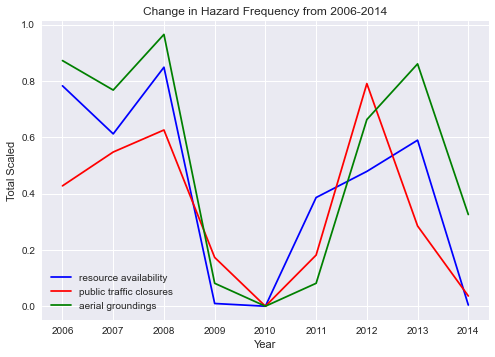

In [71]:
plt.figure()
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Change in Hazard Frequency from 2006-2014")
plt.plot(years, minmax_scale(resource_freq), color="blue", label="resource availability")
plt.plot(years, minmax_scale(traffic_freq), color="red", label="public traffic closures")
plt.plot(years,  minmax_scale(grounded_freq), color="green", label="aerial groundings")
plt.legend()
plt.show()

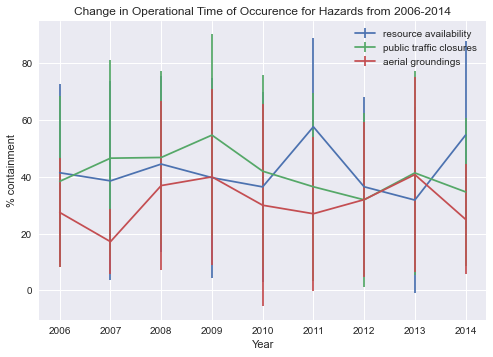

In [74]:
plt.figure()
plt.title("Change in Operational Time of Occurence for Hazards from 2006-2014")
plt.xlabel("Year")
plt.ylabel("% containment")
plt.errorbar(years, OTTOs[0], yerr=OTTO_std_dev[0], label="resource availability")
plt.errorbar(years, OTTOs[1], yerr=OTTO_std_dev[1], label="public traffic closures")
plt.errorbar(years, OTTOs[2], yerr=OTTO_std_dev[2], label="aerial groundings")
plt.legend()
plt.show()

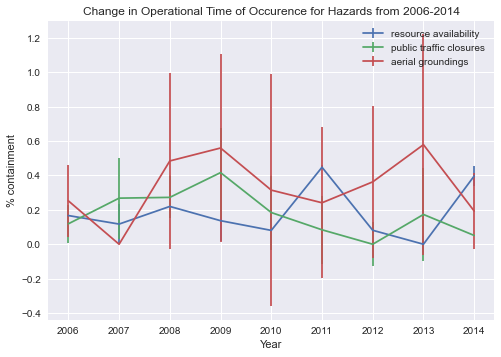

In [75]:
plt.figure()
plt.title("Change in Operational Time of Occurence for Hazards from 2006-2014")
plt.xlabel("Year")
plt.ylabel("% containment")
plt.errorbar(years, OTTOs_scaled[0], yerr=OTTO_std_dev_scaled[0], label="resource availability")
plt.errorbar(years, OTTOs_scaled[1], yerr=OTTO_std_dev_scaled[1], label="public traffic closures")
plt.errorbar(years, OTTOs_scaled[2], yerr=OTTO_std_dev_scaled[2], label="aerial groundings")
plt.legend()
plt.show()

### Correlation Matrix

In [59]:
correlation_mat_data = totals_scaled
correlation_mat_data["total Resource Issues"] = minmax_scale(resource_freq)
correlation_mat_data["total Traffic Hazards"] = minmax_scale(traffic_freq)
correlation_mat_data["total Aerial Groundings"] = minmax_scale(grounded_freq)
correlation_mat_total = pd.DataFrame(correlation_mat_data)


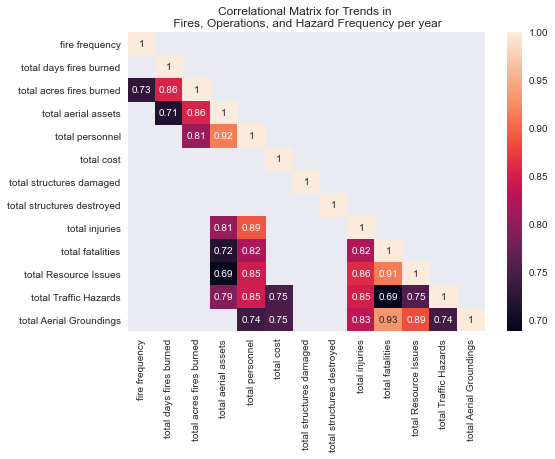

In [60]:
corrMatrix =correlation_mat_total.corr()
p_values = corr_sig(correlation_mat_total)                     # get p-Value
mask = np.invert(np.tril(p_values<0.05)) 
sn.heatmap(corrMatrix, annot=True, mask=mask)
plt.title("Correlational Matrix for Trends in \n Fires, Operations, and Hazard Frequency per year")
plt.show()

In [61]:
corrMatrix =correlation_mat_total.rcorr()
corrMatrix
#sn.heatmap(corrMatrix, annot=True)
#plt.title("Correlational Matrix for Trends in \n Fires, Operations, and Hazard Frequency per year")
#plt.show()

,fire frequency,total days fires burned,total acres fires burned,total aerial assets,total personnel,total cost,total structures damaged,total structures destroyed,total injuries,total fatalities,total Resource Issues,total Traffic Hazards,total Aerial Groundings
fire frequency,-,,*,,,,,,,,,,
total days fires burned,0.575,-,**,*,,,,,,,,,
total acres fires burned,0.727,0.856,-,**,**,,,,,,,,
total aerial assets,0.596,0.714,0.855,-,***,,,,**,*,*,*,
total personnel,0.595,0.554,0.807,0.916,-,,,,**,**,**,**,*
total cost,0.09,-0.065,0.168,0.502,0.444,-,,,,,,*,*
total structures damaged,-0.093,-0.114,-0.12,0.003,-0.29,0.357,-,,,,,,
total structures destroyed,0.408,0.345,0.663,0.535,0.52,0.429,0.068,-,,,,,
total injuries,0.537,0.259,0.651,0.805,0.89,0.617,-0.004,0.648,-,**,**,**,**
total fatalities,0.315,0.27,0.463,0.717,0.82,0.588,-0.199,0.401,0.823,-,***,*,***


# Multiple regression
typically multiple regression is used as a prediction algorithm, given a certain set of continuous inputs X=(x1,2,...xn), what is the value of continuous variable y? Multiple regression uses a linear combination of X to produce y, and the error in y/goodness of fit indicates how good the predictors are.

The importance of a predictor, xi, is evaluated by removing it from X, and seeing how the goodness of fit/error changes.

### Our goal: 
use regression to determine what the most important predictors are for the frequency of hazards. Since we have a limited number of data points (9) we will not be predicting on unseen data.

#### Inputs/Predictors: 
All operations trends, fire characteristics, and intensity
#### Output/y: 
annual frequency of hazards time series
#### Method:
for each hazard, use its frequency time series:
1. fit linear regression model to the X,y
2. calculate accuracy/error/Beta??
For each Xi:
3. Remove from X
4. repeat model fitting and accuracy
5. record orignal accuracy-removed xi accuracy -> positive large delta means importance, negative delta indicates it should be removed, small delta means little importance

Future goal: use ML to determine whether or not a hazard will occur based on past incident reports

In [62]:
from sklearn import linear_model

In [63]:
#unsused
hazard_freqs = [resource_freq, traffic_freq, grounded_freq]
hazard_freqs_scaled = [minmax_scale(freq) for freq in hazard_freqs]
totals_scaled = {feature: minmax_scale(totals[feature]) for feature in totals}

In [64]:
predictors = ["fire frequency", "total days fires burned", "total acres fires burned", "total aerial assets", "total personnel", "total cost"]
hazards = ["total Traffic Hazards", "total Resource Issues", "total Aerial Groundings"]

In [65]:
data = correlation_mat_total #uses minmax scaled frequencies and totals

In [66]:
from sklearn.metrics import mean_squared_error, accuracy_score

In [67]:
full_model_score = []
full_model_MSE = []
xi_score = {predictor+" removed score":[] for predictor in predictors}
xi_MSE = {predictor+" removed MSE":[] for predictor in predictors}
xi_score_delta = {predictor+" removed score":[] for predictor in predictors}
xi_MSE_delta = {predictor+" removed MSE":[] for predictor in predictors}
for hazard in hazards:
    X = data[predictors]
    y = data[hazard]
    regr = linear_model.LinearRegression()
    regr.fit(X,y)
    y_pred = regr.predict(X)
    model_score = regr.score(X,y)
    full_model_score.append(model_score)
    model_MSE = mean_squared_error(y_pred,y)
    full_model_MSE.append(model_MSE)
    for predictor in predictors:
        other_predictors = [pre for pre in predictors if pre!=predictor]
        X = data[other_predictors]
        y = data[hazard]
        regr = linear_model.LinearRegression()
        regr.fit(X,y)
        y_pred = regr.predict(X)
        predictor_score = regr.score(X,y)
        xi_score[predictor+" removed score"].append(predictor_score)
        predictor_MSE = mean_squared_error(y_pred,y)
        xi_MSE[predictor+" removed MSE"].append(predictor_MSE)
        
        xi_score_delta[predictor+" removed score"].append(model_score-predictor_score)
        xi_MSE_delta[predictor+" removed MSE"].append(model_MSE-predictor_MSE)

In [68]:
results_data = {"hazard":hazards, "R2 for full model":full_model_score, "MSE for full model": full_model_MSE}
results_data.update(xi_score)
results_data.update(xi_MSE)
results_df = pd.DataFrame(results_data)
results_df

,hazard,R2 for full model,MSE for full model,fire frequency removed score,total days fires burned removed score,total acres fires burned removed score,total aerial assets removed score,total personnel removed score,total cost removed score,fire frequency removed MSE,total days fires burned removed MSE,total acres fires burned removed MSE,total aerial assets removed MSE,total personnel removed MSE,total cost removed MSE
0,total Traffic Hazards,0.937481,0.004161,0.913368,0.915119,0.908269,0.936682,0.915717,0.897790,0.005766,0.005650,0.006106,0.004214,0.005610,0.006803
1,total Resource Issues,0.959386,0.004072,0.890430,0.938381,0.914140,0.915513,0.731616,0.877203,0.010987,0.006179,0.008609,0.008472,0.026912,0.012313
2,total Aerial Groundings,0.920231,0.010743,0.918761,0.920203,0.854207,0.915128,0.835483,0.894134,0.010941,0.010747,0.019636,0.011431,0.022157,0.014258


In [69]:
delta_data = {"hazard":hazards, "R2 for full model":full_model_score, "MSE for full model": full_model_MSE}
delta_data.update(xi_score_delta)
delta_data.update(xi_MSE_delta)
delta_df = pd.DataFrame(delta_data)
delta_df

,hazard,R2 for full model,MSE for full model,fire frequency removed score,total days fires burned removed score,total acres fires burned removed score,total aerial assets removed score,total personnel removed score,total cost removed score,fire frequency removed MSE,total days fires burned removed MSE,total acres fires burned removed MSE,total aerial assets removed MSE,total personnel removed MSE,total cost removed MSE
0,total Traffic Hazards,0.937481,0.004161,0.024113,0.022363,0.029212,0.000799,0.021765,0.039692,-0.001605,-0.001488,-0.001944,-0.000053,-0.001449,-0.002642
1,total Resource Issues,0.959386,0.004072,0.068957,0.021006,0.045246,0.043873,0.227770,0.082183,-0.006915,-0.002106,-0.004537,-0.004399,-0.022839,-0.008241
2,total Aerial Groundings,0.920231,0.010743,0.001470,0.000028,0.066024,0.005103,0.084748,0.026097,-0.000198,-0.000004,-0.008892,-0.000687,-0.011414,-0.003515
